In [ ]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# graphs in svg look clearer
%config InlineBackend.figure_format = 'svg'

# increase the default size of charts
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from typing import Dict, List, Tuple
import itertools as it

from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

import scipy.stats as sps

In seminars, we were introduced to the collaborative filtering methods, which recommend items based on similarity measures based on users or items. The disadvantage of these algorithms is that they provide recommendations biased towards more popular recipes. In our project we would like to address this problem to get more diversified recommendations.

By ‘diversified’ we imply diversity in terms of range of ingredients in the recipes as well as novelty which means including recipes of different popularity levels. Thus, in our research we measure the diversity and novelty in collaborative filtering approaches using 4 metrics and then apply a new model to our data and compare the values of chosen criteria computed for this model with item- and user-based approaches. The main problem we are solving has a predictive nature as we are forecasting which recipes the user will add to their profile (like).


# 0. Data Preprocessing:

In [ ]:
user_recipe_full = pd.read_csv('fe_user_recipe_matrix.csv')
user_recipe_train = pd.read_csv('user_recipe_matrix_train_only.csv')
recipe_ingr = pd.read_csv('fe_recipe_attribute_matrix_file84.csv')

user_recipe_train.replace(2, np.nan, inplace=True)

In [ ]:
user_recipe_train['user_id'] = user_recipe_train.index
user_recipe_full['user_id'] = user_recipe_full.index

user_recipe_transformed = pd.melt(user_recipe_train,
                                  id_vars='user_id',
                                  var_name='recipe_name',
                                  value_name='y')

user_recipe_transformed['recipe_name'] = \
user_recipe_transformed['recipe_name'].apply(lambda x: x.split(':')[0])

user_recipe_full_transformed = pd.melt(user_recipe_full, id_vars='user_id',
                                 var_name='recipe_name', value_name='y')

user_recipe_full_transformed['recipe_name'] = \
user_recipe_full_transformed['recipe_name'].apply(lambda x: x.split(':')[0])

user_recipe_transformed = user_recipe_transformed.merge(recipe_ingr, on=['recipe_name'])

<ipython-input-3-62a5b818552c>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_recipe_train['user_id'] = user_recipe_train.index


Let's delete popularity_order, since the meaning of this column does not match the available data (proved it during seminars):

In [ ]:
user_recipe_transformed.drop(['popularity_order'], axis=1, inplace=True)

user_recipe_transformed_train = user_recipe_transformed[~user_recipe_transformed['y'].isnull()]  # train
user_recipe_transformed_test = user_recipe_transformed[user_recipe_transformed['y'].isnull()]  # test

# 1. Predict the values in the cells:

For each of the approaches, we decided to use the optimal number of neighbours shown in our home asignment on recommendation systems:

For user-based approach: number of neighbours = 5

For item-based approach: number of neighbours = 10

**User-based approach with Jaccard similarity:**

In [ ]:
user_recipe_train.drop(['user_id'], axis=1, inplace=True)
train_array = user_recipe_train.values

In [ ]:
def get_ratings_knn(sim_array: pd.DataFrame, k: int) -> np.array:
    means = np.nanmean(train_array, axis=1)
    ratings = np.zeros(train_array.shape)
    U = train_array.shape[0]

    for u in tqdm(range(U)):
        for i in np.argwhere(np.isnan(train_array[u])).ravel():
            rated = np.argwhere(~np.isnan(train_array[:,i])).ravel()
            all_neighbors = np.argsort(sim_array[u])
            k_neighbors = all_neighbors[np.isin(all_neighbors, rated)][-k:]
            ratings[u, i] = means[u] + np.dot(sim_array[u][k_neighbors],
                                              train_array[:, i][k_neighbors] -
                                              means[k_neighbors]) / np.sum(sim_array[u][k_neighbors])

    return ratings

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
jac_sim = 1 - pairwise_distances(user_recipe_train.T.to_numpy(), metric='jaccard')
jac_sim_df = pd.DataFrame(
    1 - pairwise_distances(user_recipe_train.T.to_numpy(), metric='jaccard'),
    index= user_recipe_train.T.columns, columns= user_recipe_train.T.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [ ]:
jac_sim_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,0.082781,0.083601,0.057239,0.125628,0.109718,0.080000,0.112601,0.055944,0.073684,...,0.124161,0.085642,0.105634,0.131646,0.118457,0.081461,0.078431,0.102649,0.115942,0.115987
1,0.082781,1.000000,0.098684,0.076125,0.120907,0.093458,0.099315,0.107527,0.091241,0.074468,...,0.070968,0.097436,0.068729,0.096296,0.113260,0.120235,0.104730,0.089109,0.126844,0.089506
2,0.083601,0.098684,1.000000,0.110727,0.117936,0.100610,0.099668,0.087629,0.069204,0.083045,...,0.106796,0.114504,0.099315,0.118227,0.110215,0.116809,0.104918,0.079365,0.091922,0.077151
3,0.057239,0.076125,0.110727,1.000000,0.127937,0.079872,0.100000,0.093151,0.087452,0.098485,...,0.066890,0.115591,0.071942,0.128272,0.086351,0.098214,0.090278,0.089347,0.091716,0.103896
4,0.125628,0.120907,0.117936,0.127937,1.000000,0.107981,0.116162,0.158696,0.126005,0.107050,...,0.110294,0.170576,0.142857,0.153061,0.172260,0.156322,0.108911,0.110837,0.148402,0.156098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.081461,0.120235,0.116809,0.098214,0.156322,0.117486,0.055710,0.121718,0.062500,0.090634,...,0.101695,0.182482,0.094955,0.133183,0.105516,1.000000,0.084507,0.114943,0.131105,0.135359
996,0.078431,0.104730,0.104918,0.090278,0.108911,0.106250,0.083612,0.077922,0.082437,0.081272,...,0.087662,0.110825,0.090278,0.131646,0.088472,0.084507,1.000000,0.095395,0.132353,0.130159
997,0.102649,0.089109,0.079365,0.089347,0.110837,0.085106,0.065147,0.108753,0.085409,0.095745,...,0.086817,0.133159,0.108392,0.113861,0.111413,0.114943,0.095395,1.000000,0.099150,0.104615
998,0.115942,0.126844,0.091922,0.091716,0.148402,0.129834,0.138138,0.082949,0.108696,0.052478,...,0.160714,0.114679,0.094955,0.113082,0.135468,0.131105,0.132353,0.099150,1.000000,0.138504


In [ ]:
jac_ratings = get_ratings_knn(jac_sim_df, 5)

  0%|          | 0/1000 [00:00<?, ?it/s]

**Item-based approach with Cosine similarity:**

In [ ]:
def get_ratings_knn_items(sim_array: pd.DataFrame, k: int) -> np.array:
    means = np.nanmean(user_recipe_train.values.T, axis=1)
    ratings = np.zeros(user_recipe_train.values.T.shape)
    U = user_recipe_train.values.T.shape[0]

    for u in tqdm(range(U)):
        for i in np.argwhere(np.isnan(user_recipe_train.values.T[u])).ravel():
            rated = np.argwhere(~np.isnan(user_recipe_train.values.T[:,i])).ravel()
            all_neighbors = np.argsort(sim_array[u])
            k_neighbors = all_neighbors[np.isin(all_neighbors, rated)][-k:]
            ratings[u, i] = means[u] + np.dot(sim_array[u][k_neighbors],
                                              user_recipe_train.values.T[:, i][k_neighbors] -
                                              means[k_neighbors]) / np.sum(sim_array[u][k_neighbors])

    return ratings

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
user_recipe_train_no_na = user_recipe_train.copy().fillna(user_recipe_train.mean())

In [ ]:
cos_sim = cosine_similarity(user_recipe_train_no_na)

In [ ]:
cos_ratings = get_ratings_knn_items(cos_sim, 10)

  0%|          | 0/1000 [00:00<?, ?it/s]

# 2. Create recommendations for n_rec = 10:



Here, we show in a little more detail how we create recommendations and compute metrics for number of recommendations = 10. We will then use a similar approach for different number of recommended items when creating graphs and interpreting the results.

In [ ]:
recommendations_jac = np.argsort(jac_ratings, axis=1)[:, -10:]

In [ ]:
recommendations_cos = np.argsort(cos_ratings, axis=1)[:, -10:]

In [ ]:
data = []

for user_id, recipies in enumerate(recommendations_jac):
    for rank, item_id in enumerate(recipies):
        data.append([user_id, item_id, rank + 1])

reco_jac = pd.DataFrame(data, columns=['user_id', 'item_id', 'rank'])
reco_jac

,user_id,item_id,rank
0,0,949,1
1,0,602,2
2,0,501,3
3,0,883,4
4,0,661,5
...,...,...,...
9995,999,431,6
9996,999,979,7
9997,999,507,8
9998,999,909,9


In [ ]:
data = []

for user_id, recipies in enumerate(recommendations_cos):
    for rank, item_id in enumerate(recipies):
        data.append([user_id, item_id, rank + 1])

reco_cos = pd.DataFrame(data, columns=['user_id', 'item_id', 'rank'])
reco_cos

,user_id,item_id,rank
0,0,465,1
1,0,111,2
2,0,536,3
3,0,315,4
4,0,80,5
...,...,...,...
9995,999,590,6
9996,999,798,7
9997,999,359,8
9998,999,627,9


# 3. Data preparation for calculation of metrics:

In order to compute some of the metrics, we also need to create dataframes with previous interactions of users and with features of items.

We know that we were given the table where 10% of the iteractions of users are NaN, so we account for that when creating previous iteractions dataframe:

In [ ]:
without_nan = np.argsort(user_recipe_train.copy()).iloc[:, :900]

data = []

for user_id, recipies in enumerate(without_nan.values):
    for _, item_id in enumerate(recipies):
        data.append([user_id, item_id])

reco_prev = pd.DataFrame(data, columns=['user_id', 'item_id'])
reco_prev

,user_id,item_id
0,0,0
1,0,622
2,0,623
3,0,624
4,0,625
...,...,...
899995,999,179
899996,999,602
899997,999,855
899998,999,747


Features dataframe:

In [ ]:
features = recipe_ingr.copy()
features['random_order'] = features['random_order'] - 1
features = features.drop(['popularity_order', 'recipe_name'], axis = 1)

In [ ]:
features

,random_order,butter,chicken_breast_half,tomato,Parmesan_cheese,soy_sauce,parsley,ground_beef,all-purpose_flour,Cheddar_cheese,...,chorizo_sausage,onion_flake,ground_beef_chuck,puff_pastry_shell,saffron_thread,peach_preserves,rock_lobster_tail,Fontina_cheese,bake,simmer
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,996,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
997,997,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
998,998,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4. Metrics for n_rec = 10:

#### 4.1. Mean Inverse User Frequency

$$ MIUF = - \frac{\sum\limits_{\substack{i=1}}^{k+1} log_2 (\frac{users(i)}{n\_users})}{k} $$

- $ users(i) $ - number of users that previously interacted with item with rank $i$

- $ n\_users $ - the overall number of users in previous interactions.

- $ k $ – number of items at the top of recommendations list that will be used to calculate the metric


This metric is used to estimate mean novelty of items in recommendations. As you can see from the formula, novelty of the recipe is inversely proportional to the number of users who interacted with it.

In [ ]:
def mean_inv_user_frequency(recommendations: pd.DataFrame, prev_inter: pd.DataFrame):
    n_users = prev_inter['user_id'].nunique()
    n_users_per_item = prev_inter.groupby('item_id')['user_id'].nunique()

    rec = recommendations[['user_id', 'item_id']].copy()
    rec['users_per_item'] = rec['item_id'].map(n_users_per_item)
    rec['IUF'] = -np.log2(rec['users_per_item'] / n_users)
    return rec.groupby('user_id')['IUF'].mean().mean()

In [ ]:
mean_inv_user_frequency(reco_jac, reco_prev)

0.1529189387010678

In [ ]:
mean_inv_user_frequency(reco_cos, reco_prev)

0.15197160901679121

Additionally, this metric can be computed using special python library:

In [ ]:
! pip install rectools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 22.2 MB/s eta 0:00:00


In [ ]:
from rectools.metrics import MeanInvUserFreq

In [ ]:
MeanInvUserFreq(k=10).calc(reco_jac, reco_prev)

0.1529189387010678

In [ ]:
MeanInvUserFreq(k=10).calc(reco_cos, reco_prev)

0.15197160901679121

As we see, both methods - ours and imported from rectools - yield the same result.

####4.2. Intra List Diversity


$$ ILD = \frac{\sum\limits_{\substack{i=1}}^{k+1} \sum\limits_{\substack{j=1}}^{k+1} d(i, j)}{k \cdot (k-1)} $$

- $k$ – number of items at the top of recommendations list that will be used to calculate metric.
- $d(i, j)$ is distance between recommended items with rank $i$ and rank $j$.

This metric measures diversity of our recommendations by estimating average pairwise distance between items in user recommendations. The greater is this distance, the more dissimilar recommendations we give to our users.

As a measure of distance here, we decided to use the Hamming distance between one-hot vectors.

In [ ]:
from itertools import combinations

In [ ]:
def hamming_distances(pairs: pd.Series, features: pd.DataFrame):
    items_0, items_1 = pairs.str[1].values, pairs.str[0].values
    features_0, features_1 = features.reindex(items_0).values, features.reindex(items_1).values
    return np.sum(features_0 != features_1, axis=1)

def intra_list_diversity(recommendations: pd.DataFrame, features: pd.DataFrame):
    rec_item_pairs = recommendations.groupby('user_id')['item_id'].apply(lambda x: list(combinations(x, 2)))
    rec_item_pairs = rec_item_pairs.reset_index().explode('item_id').rename(columns={'item_id' : 'item_pairs'})

    rec_item_pairs['dist'] = hamming_distances(rec_item_pairs['item_pairs'], features)
    return rec_item_pairs.groupby('user_id')['dist'].mean().mean()

In [ ]:
intra_list_diversity(reco_jac, features)

5.422577777777778

In [ ]:
intra_list_diversity(reco_cos, features)

5.319911111111111

This metric can also be computed using rectools library:

In [ ]:
from rectools.metrics.distances import PairwiseHammingDistanceCalculator
from rectools.metrics import IntraListDiversity
calculator = PairwiseHammingDistanceCalculator(features)

In [ ]:
IntraListDiversity(k=10, distance_calculator=calculator).calc(reco_jac)

5.422577777777778

In [ ]:
IntraListDiversity(k=10, distance_calculator=calculator).calc(reco_cos)

5.319911111111111

Once again, moth methods yield the same result.

#### 4.3. Coverage

$$ coverage = \frac{I}{N} * 100\% $$

- $I$ - the number of unique items the model recommends
- $N$ - total number of unique items in the training data

This metrics shows a proportion of unique items that a given recommendation system is able to offer to all users.

In [ ]:
def coverage(recommendations: pd.DataFrame, prev_inter: pd.DataFrame):
  rec_items = recommendations['item_id'].nunique()
  total_unique_items = prev_inter['item_id'].nunique()
  return rec_items / total_unique_items

In [ ]:
coverage(reco_jac, reco_prev)

0.855

In [ ]:
coverage(reco_cos, reco_prev)

0.999

#### 4.4. Coverage Diversity

$$ H(p) = - \sum_{\substack{i \in I}} p(i) \cdot log \; p(i)$$

- $p(i) $ - the share of recommendations of recipe $i \in I$ among all recommendations for this recommendation system.
- $I$ - the number of unique items the model recommends

Diversity here is measured as the entropy of such a distribution.

In [ ]:
def coverage_diversity(recommendations: pd.DataFrame):
  H = []
  all = recommendations['item_id'].count()
  for item in recommendations['item_id'].unique():
    p_i = recommendations['item_id'][recommendations['item_id'] == item].count() / all
    log_i = np.log(p_i)
    H.append(p_i * log_i)

  return - sum(H)

In [ ]:
coverage_diversity(reco_jac)

6.183909284731305

In [ ]:
coverage_diversity(reco_cos)

6.790263804654596

# 5. Graphs:

In [ ]:
def get_diversity_metrics(ratings: np.array, reco_prev: pd.DataFrame, features: pd.DataFrame, top_N: int):

    recommendations = np.argsort(ratings, axis=1)[:, -top_N:]

    data = []
    for user_id, recipies in enumerate(recommendations):
        for rank, item_id in enumerate(recipies):
            data.append([user_id, item_id, rank + 1])

    reco = pd.DataFrame(data, columns=['user_id', 'item_id', 'rank'])
    reco

    mean_inv_user_frequency_metric = mean_inv_user_frequency(reco, reco_prev)
    intra_list_diversity_metric = intra_list_diversity(reco, features)
    coverage_metric = coverage(reco, reco_prev)
    coverage_diversity_metric = coverage_diversity(reco)

    metrics = {'mean_inv_user_frequency': mean_inv_user_frequency_metric, 'intra_list_diversity': intra_list_diversity_metric, 'coverage': coverage_metric,
              'coverage_diversity': coverage_diversity_metric}

    return metrics

In [ ]:
Ns = [3, 5, 7, 10, 15]

In [ ]:
names = ['mean_inv_user_frequency', 'intra_list_diversity', 'coverage', 'coverage_diversity']

User based:

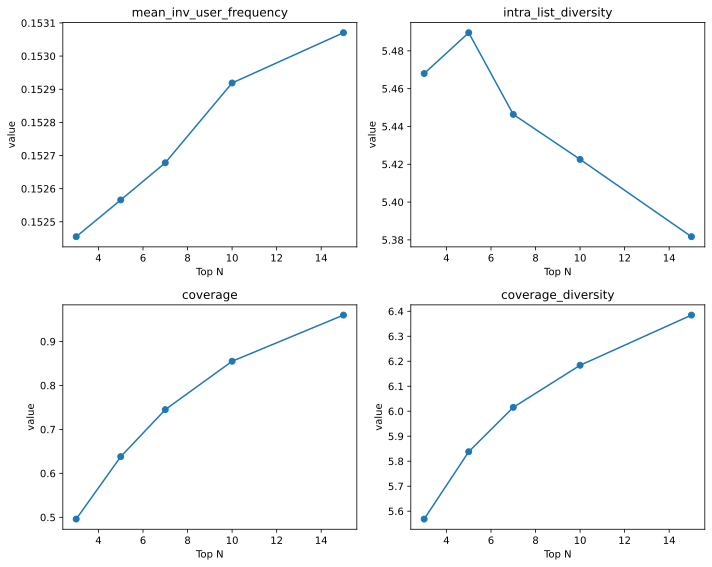

In [ ]:
metrics = [get_diversity_metrics(jac_ratings, reco_prev, features, N) for N in Ns]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, metric in enumerate(names):
    values = [entry[metric] for entry in metrics]
    row, col = divmod(i, 2)
    axes[row, col].plot(Ns, values, marker='o')
    axes[row, col].set_title(metric)
    axes[row, col].set_xlabel('Top N')
    axes[row, col].set_ylabel('value')

plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(metrics)
df['Top N'] = Ns
df.set_index('Top N', inplace=True)
df

,mean_inv_user_frequency,intra_list_diversity,coverage,coverage_diversity
Top N,,,,
3,0.152455,5.468000,0.496,5.568433
5,0.152566,5.489600,0.638,5.838011
7,0.152678,5.446381,0.745,6.015544
10,0.152919,5.422578,0.855,6.183909
15,0.153071,5.381676,0.960,6.384769


Item based:

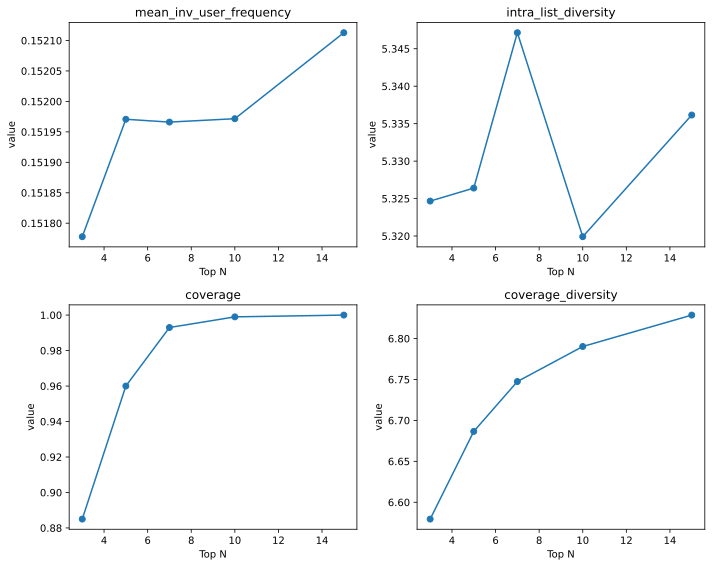

In [ ]:
metrics = [get_diversity_metrics(cos_ratings, reco_prev, features, N) for N in Ns]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, metric in enumerate(names):
    values = [entry[metric] for entry in metrics]
    row, col = divmod(i, 2)
    axes[row, col].plot(Ns, values, marker='o')
    axes[row, col].set_title(metric)
    axes[row, col].set_xlabel('Top N')
    axes[row, col].set_ylabel('value')

plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(metrics)
df['Top N'] = Ns
df.set_index('Top N', inplace=True)
df

,mean_inv_user_frequency,intra_list_diversity,coverage,coverage_diversity
Top N,,,,
3,0.151778,5.324667,0.885,6.579447
5,0.151971,5.326400,0.960,6.686564
7,0.151966,5.347143,0.993,6.747463
10,0.151972,5.319911,0.999,6.790264
15,0.152113,5.336152,1.000,6.828629


#6. Latent factor model

In the seminar we used item and user-based approaches based on k-nearest neighbours algorithm. However, there are some problems of this model:

* Hard to choose the appropriate metrics to compute the similarity
(Pearson’s correlation is not the best choice)

* The recommendations are biased towards recipes that have the most user interactions.

* Item cold-start problem: new recipe will rarely occur as a recommendation


One possible solution: latent factor model with biases ($b_u$, $b_i$) equal to zero and embeddings ($p_u$, $q_i$) equal to ones.

$$ score_{ui} = b_u + b_i + p_u \cdot q_i = b_u + b_i + cos(p_u, q_i) \cdot ||{p_u}|| \cdot ||{q_i}||$$

$p_u$ - embeddings on matrix of user interactions

$p_u$ - embeddings on matrix of items

$b_u$ - user bias

$b_i$ - item bias

In [ ]:
! pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808330 sha256=c12659ba0a474cac5a93ebd304db03e5e53dd006586e31cec759649343de2e8e
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
! pip install transliterate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.1 MB/s eta 0:00:00


In [ ]:
from copy import deepcopy
from itertools import combinations
import pickle
import typing as tp
from zipfile import ZipFile

from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
from transliterate import translit

In [ ]:
%%time

lfm_dataset = LFMDataset()
lfm_dataset.fit(
    users=user_recipe_transformed_train["user_id"].values,
    items=user_recipe_transformed_train["random_order"].values,
)

train_matrix, _ = lfm_dataset.build_interactions(zip(*user_recipe_transformed_train[["user_id", "random_order"]].values.T))

CPU times: user 2.74 s, sys: 9.1 ms, total: 2.75 s
Wall time: 2.76 s


In [ ]:
%%time
RANDOM_STATE = 42
lfm_model = LightFM(
    learning_rate=0.01,
    loss='warp',
    no_components=64,
    random_state=RANDOM_STATE
)
lfm_model.fit(
    interactions=train_matrix,
    epochs=20,
    num_threads=20,
);

CPU times: user 1min 36s, sys: 97.3 ms, total: 1min 36s
Wall time: 56.3 s


In [ ]:
id_item_mapping = {v: k for k, v in lfm_dataset._item_id_mapping.items()}

In [ ]:
def get_n_recommendations_for_user(
    user_id: str,
    model: LightFM,
    train_matrix: coo_matrix,
    user_to_id: tp.Dict[str, int],
    id_to_item: tp.Dict[int, str],
    n_recommendations: int
) -> pd.DataFrame:
    user_inner_id = user_to_id[user_id]
    scores = model.predict(
        user_ids=user_inner_id,
        item_ids=np.arange(train_matrix.shape[1]),
        num_threads=20
    )
    user_watched_items = train_matrix.col[train_matrix.row == user_inner_id]
    scores[user_watched_items] = -np.inf

    recommended_item_inner_ids = np.argpartition(scores, -np.arange(n_recommendations))[
        -n_recommendations:
    ][::-1]
    recommended_item_ids = [id_to_item[x] for x in recommended_item_inner_ids]
    return recommended_item_ids


Let's calculate our metrics for this model:

In [ ]:
def get_diversity_metrics(reco_prev: pd.DataFrame, features: pd.DataFrame, top_N: int):

    data = []
    for i in range(1000):
        recommended_items = get_n_recommendations_for_user(
            user_id=i,
            model=lfm_model,
            train_matrix=train_matrix,
            user_to_id=lfm_dataset._user_id_mapping,
            id_to_item=id_item_mapping,
            n_recommendations=top_N
        )
        for k in range(len(recommended_items)):
             data.append([i, recommended_items[k], k + 1])

    recommendations = pd.DataFrame(data, columns=['user_id', 'item_id', 'rank'])
    recommendations

    mean_inv_user_frequency_metric = mean_inv_user_frequency(recommendations, reco_prev)
    intra_list_diversity_metric = intra_list_diversity(recommendations, features)
    coverage_metric = coverage(recommendations, reco_prev)
    coverage_diversity_metric = coverage_diversity(recommendations)

    metrics = {'mean_inv_user_frequency': mean_inv_user_frequency_metric, 'intra_list_diversity': intra_list_diversity_metric, 'coverage': coverage_metric,
              'coverage_diversity': coverage_diversity_metric}

    return metrics

In [ ]:
Ns = [3,5,7,10,15]
names = ['mean_inv_user_frequency', 'intra_list_diversity', 'coverage', 'coverage_diversity']

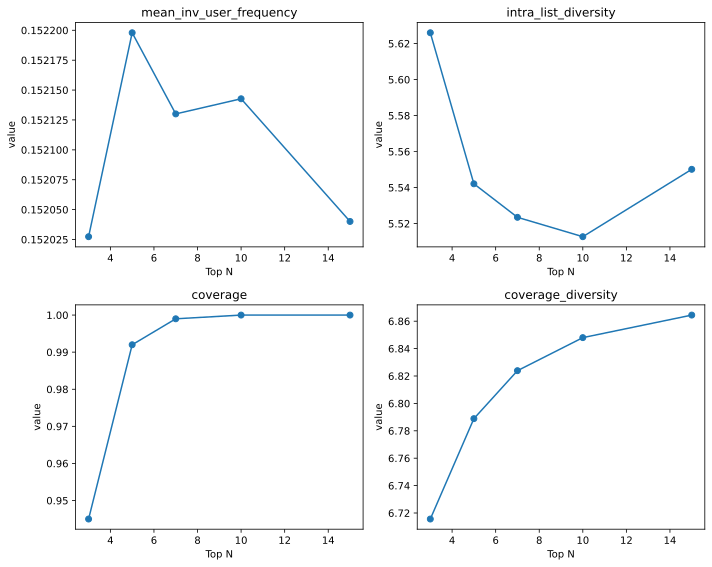

In [ ]:
metrics = [get_diversity_metrics(reco_prev, features, N) for N in Ns]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, metric in enumerate(names):
    values = [entry[metric] for entry in metrics]
    row, col = divmod(i, 2)
    axes[row, col].plot(Ns, values, marker='o')
    axes[row, col].set_title(metric)
    axes[row, col].set_xlabel('Top N')
    axes[row, col].set_ylabel('value')

plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(metrics)
df['Top N'] = Ns
df.set_index('Top N', inplace=True)
df

,mean_inv_user_frequency,intra_list_diversity,coverage,coverage_diversity
Top N,,,,
3,0.152027,5.626000,0.945,6.715617
5,0.152198,5.542100,0.992,6.788884
7,0.152130,5.523476,0.999,6.823901
10,0.152143,5.512711,1.000,6.848016
15,0.152040,5.550143,1.000,6.864472


Now, let's try to remove the bias towards popular recipes:

In [ ]:
lfm_model_cos = deepcopy(lfm_model)

lfm_model_cos.item_biases = np.zeros_like(lfm_model_cos.item_biases)
lfm_model_cos.user_biases = np.zeros_like(lfm_model_cos.user_biases)

lfm_model_cos.item_embeddings = normalize(lfm_model_cos.item_embeddings)
lfm_model_cos.user_embeddings = normalize(lfm_model_cos.user_embeddings)

In [ ]:
def get_diversity_metrics_1(reco_prev: pd.DataFrame, features: pd.DataFrame, top_N: int):

    data = []
    for i in range(1000):
        recommended_items = get_n_recommendations_for_user(
            user_id=i,
            model=lfm_model_cos,
            train_matrix=train_matrix,
            user_to_id=lfm_dataset._user_id_mapping,
            id_to_item=id_item_mapping,
            n_recommendations=top_N
        )
        for k in range(len(recommended_items)):
             data.append([i, recommended_items[k], k + 1])

    recommendations = pd.DataFrame(data, columns=['user_id', 'item_id', 'rank'])
    recommendations

    mean_inv_user_frequency_metric = mean_inv_user_frequency(recommendations, reco_prev)
    intra_list_diversity_metric = intra_list_diversity(recommendations, features)
    coverage_metric = coverage(recommendations, reco_prev)
    coverage_diversity_metric = coverage_diversity(recommendations)

    metrics = {'mean_inv_user_frequency': mean_inv_user_frequency_metric, 'intra_list_diversity': intra_list_diversity_metric, 'coverage': coverage_metric,
              'coverage_diversity': coverage_diversity_metric}

    return metrics

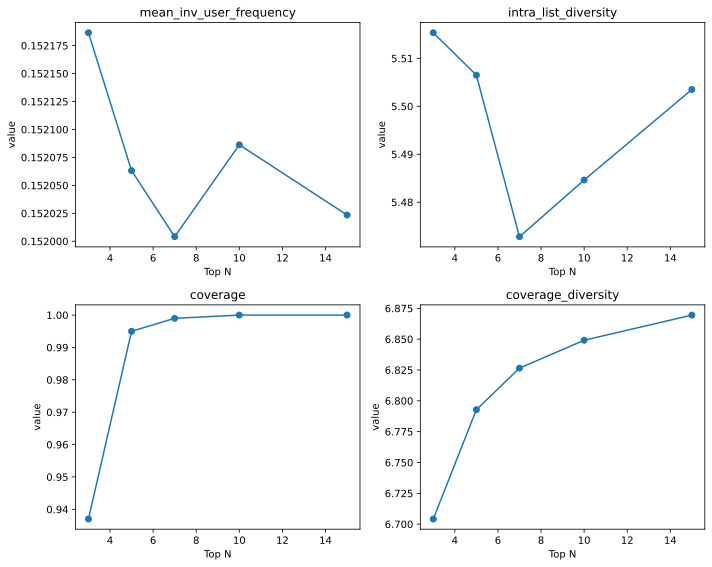

In [ ]:
metrics = [get_diversity_metrics_1(reco_prev, features, N) for N in Ns]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, metric in enumerate(names):
    values = [entry[metric] for entry in metrics]
    row, col = divmod(i, 2)
    axes[row, col].plot(Ns, values, marker='o')
    axes[row, col].set_title(metric)
    axes[row, col].set_xlabel('Top N')
    axes[row, col].set_ylabel('value')

plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(metrics)
df['Top N'] = Ns
df.set_index('Top N', inplace=True)
df

,mean_inv_user_frequency,intra_list_diversity,coverage,coverage_diversity
Top N,,,,
3,0.152187,5.515333,0.937,6.704156
5,0.152063,5.506500,0.995,6.792811
7,0.152004,5.472810,0.999,6.826515
10,0.152086,5.484622,1.000,6.849122
15,0.152024,5.503505,1.000,6.869518


# Results

Both user-based and item-based approaches give quite similar results: for mean inverse user frequency (MIUF), coverage and coverage diversity we can see an increasing (or not-decreasing) trend. We can attribute this trend to the meaning of these metrics: probability of choosing less popular items and more unique items rises with the number of items recommended to each user so MIUF, coverage and coverage diversity increase. Intra list diversity shows almost consistent decreasing trend for user-based approach (this is due to logic of the approach that uses distance in users’ preferences - the more items we offer, the less dissimilar they will be), but there is no consistent trend for item-based approach (as it uses similarity between items but not user preferences).

For new model trends for coverage and coverage diversity remain the same and explanation for this could be the same as for previous approaches. For MIUF we can see an inconsistent decreasing trend (this is due to the fact that the new model provides less popular-biased recommendations).

# New model effectiveness

As mentioned above, we assume a 10\% difference in estimated metrics as a significant result. Based on this threshold we can identify whether the new model provides significant improvement in novelty and diversity of recommendations.
For metrics coverage and coverage diversity (example, N=3, 5, 7) we’ve got significant improvements for user-based approach
For metrics ILD for both approaches and coverage and coverage diversity for item based approaches (for all N) there are improvements, but they are not significant in terms of our threshold.

For MIUF there is no considerable difference at all.
Thus the new model provides some significant improvements in diversity and novelty in comparison to user-based approach and not significant improvements in diversity in comparison to item-based approach. Implementers of recommendation systems can use the LFM model to make recommendations more diverse and eliminate precedence of more popular items instead of a user-based approach.